# Import Libraries

In [1]:
#Load the required libraries

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

import time


import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
bitcoin_df = pd.read_csv("../data/BTCUSDT_final_clean.csv")

In [3]:
bitcoin_df.head()

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,3.675857e+06,7640.0,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,6.365953e+06,9033.0,570.721419,4.114804e+06
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,4.736719e+06,7466.0,357.180263,2.582514e+06
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,5.667367e+06,8337.0,394.810811,2.854987e+06
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,3.379094e+06,5896.0,243.514706,1.759053e+06


Here's a breakdown of each feature:

- **date**: This represents the opening time

- **open**: This refers to the opening price of the trading instrument at the given period.

- **high**: This represents the highest price reached by the trading instrument during the specified period.

- **low**: This denotes the lowest price reached by the trading instrument during the specified period.

- **close**: This indicates the closing price of the trading instrument at the given period.

- **volume**: This refers to the total volume, typically the quantity of the trading instrument, traded during the specified period.


- **quote_volume**: This refers to the total volume in terms of the quote asset. The quote asset is the asset used to determine the value of the trading instrument.

- **count**: This represents the number of trades that occurred during the specified period.

- **taker_buy_volume**: This denotes the volume of the quote asset bought by takers (market takers) during the specified period.

- **taker_buy_quote_volume**: This represents the volume of the base asset bought by takers (market takers) during the specified period.

In [4]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    29928 non-null  object 
 1   open                    29928 non-null  float64
 2   high                    29928 non-null  float64
 3   low                     29928 non-null  float64
 4   close                   29928 non-null  float64
 5   volume                  29928 non-null  float64
 6   quote_volume            29928 non-null  float64
 7   count                   29928 non-null  float64
 8   taker_buy_volume        29928 non-null  float64
 9   taker_buy_quote_volume  29928 non-null  float64
dtypes: float64(9), object(1)
memory usage: 2.3+ MB


# Datetime Conversion

In [5]:
# Converting the Date column from object to datetime
bitcoin_df[["date"]] = bitcoin_df[["date"]].apply(pd.to_datetime)

In [6]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    29928 non-null  datetime64[ns]
 1   open                    29928 non-null  float64       
 2   high                    29928 non-null  float64       
 3   low                     29928 non-null  float64       
 4   close                   29928 non-null  float64       
 5   volume                  29928 non-null  float64       
 6   quote_volume            29928 non-null  float64       
 7   count                   29928 non-null  float64       
 8   taker_buy_volume        29928 non-null  float64       
 9   taker_buy_quote_volume  29928 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 2.3 MB


# Modeling

In [7]:
bitcoin_df.head()

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,3.675857e+06,7640.0,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,6.365953e+06,9033.0,570.721419,4.114804e+06
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,4.736719e+06,7466.0,357.180263,2.582514e+06
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,5.667367e+06,8337.0,394.810811,2.854987e+06
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,3.379094e+06,5896.0,243.514706,1.759053e+06


## Hourly Dataframe

In [8]:
# Define the features and target variable
columns = ['open', 'high', 'low', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

X = bitcoin_df[columns]
y = bitcoin_df['close']

# Split the data into training and test sets (we select a small test set due to the length of the iterations)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, shuffle=False)

# Print the shape of the training and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (28730, 7)
y_train shape: (28730,)
X_test shape: (1198, 7)
y_test shape: (1198,)


In [9]:
# Creating a list of values

training_list = list(y_train)
test_list = list(y_test)

In [10]:
series = bitcoin_df.close

arima_model = pm.auto_arima(series,
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            trend='t',
                            seasonal=False,
                            trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=416496.964, Time=5.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=416498.889, Time=7.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=416498.887, Time=6.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=416496.964, Time=3.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=416501.367, Time=1.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 25.648 seconds


In [11]:
hourly_predictions = []

start_time = time.time()  # Start measuring iteration start time

for i in range(len(y_test)):
    model = ARIMA(training_list, order=(0, 1, 0))
    model_fit = model.fit()
    hourly_forecast = model_fit.forecast()[0]  # Use steps=1 to forecast only one step ahead

    hourly_predictions.append(hourly_forecast)

    test_i = test_list[i]
    training_list.append(test_i)


    # Print the current iteration number every 100 iterations
    if (i + 1) % 100 == 0:
        print("Iteration:", i + 1)
        end_time = time.time()  # Record iteration end time
        iteration_time = end_time - start_time  # Calculate iteration time
        print("Iteration time:", iteration_time / 60, "minutes")  # Convert iteration time to minutes


Iteration: 100
Iteration time: 0.5456366697947185 minutes
Iteration: 200
Iteration time: 1.0435349782307943 minutes
Iteration: 300
Iteration time: 1.5260432918866476 minutes
Iteration: 400
Iteration time: 2.0823103109995524 minutes
Iteration: 500
Iteration time: 2.5860448400179545 minutes
Iteration: 600
Iteration time: 3.092129286130269 minutes
Iteration: 700
Iteration time: 3.731871036688487 minutes
Iteration: 800
Iteration time: 4.2538381536801655 minutes
Iteration: 900
Iteration time: 4.754377011458079 minutes
Iteration: 1000
Iteration time: 5.221885279814402 minutes
Iteration: 1100
Iteration time: 5.698587640126546 minutes


In [12]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                29927
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -208240.019
Date:                Sun, 13 Aug 2023   AIC                         416482.039
Time:                        16:37:23   BIC                         416490.345
Sample:                             0   HQIC                        416484.704
                              - 29927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       6.48e+04    159.121    407.249      0.000    6.45e+04    6.51e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):            507931.01
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plots Hourly

In [13]:
X_test['Hourly_Forecast_ARIMA']= hourly_predictions

X_test

,open,high,low,volume,quote_volume,taker_buy_volume,taker_buy_quote_volume,Hourly_Forecast_ARIMA
28730,30170.80,30170.80,29811.82,5625.33965,1.685406e+08,2518.73553,7.545659e+07,30170.80
28731,29916.16,29989.19,29858.19,2277.12119,6.814636e+07,1202.31434,3.598152e+07,29916.16
28732,29922.04,29995.35,29887.03,1539.74214,4.610840e+07,819.31869,2.453503e+07,29922.04
28733,29978.59,29999.23,29891.46,1493.93185,4.472736e+07,685.80936,2.053273e+07,29978.58
28734,29919.99,29956.81,29850.00,1412.52475,4.224635e+07,732.40167,2.190569e+07,29920.00
...,...,...,...,...,...,...,...,...
29923,27037.06,27123.43,27000.20,1064.24189,2.879819e+07,482.38594,1.305342e+07,27037.06
29924,27010.57,27116.13,27005.16,835.43916,2.262138e+07,440.84291,1.193703e+07,27010.57
29925,27114.19,27119.77,27045.61,644.01902,1.744376e+07,254.03940,6.879695e+06,27114.20
29926,27090.78,27193.24,27084.92,999.11868,2.711602e+07,517.76569,1.405207e+07,27090.79


In [14]:
merged_df = pd.merge(bitcoin_df[["date", "close"]], X_test['Hourly_Forecast_ARIMA'], left_index=True, right_index=True)

merged_df

,date,close,Hourly_Forecast_ARIMA
28730,2023-04-12 02:00:00,29916.16,30170.80
28731,2023-04-12 03:00:00,29922.04,29916.16
28732,2023-04-12 04:00:00,29978.58,29922.04
28733,2023-04-12 05:00:00,29920.00,29978.58
28734,2023-04-12 06:00:00,29932.89,29920.00
...,...,...,...
29923,2023-05-31 19:00:00,27010.57,27037.06
29924,2023-05-31 20:00:00,27114.20,27010.57
29925,2023-05-31 21:00:00,27090.79,27114.20
29926,2023-05-31 22:00:00,27183.98,27090.79


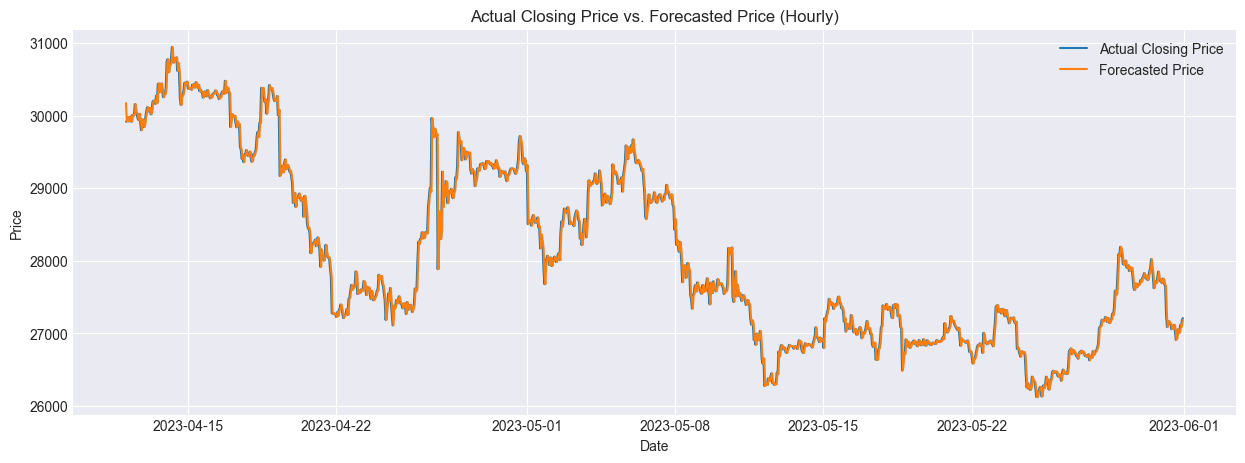

In [15]:
plt.figure(figsize=(15, 5))

plt.plot(merged_df['date'], merged_df['close'], label='Actual Closing Price')
plt.plot(merged_df['date'], merged_df['Hourly_Forecast_ARIMA'], label='Forecasted Price')

plt.xlabel('Date')
plt.ylabel('Price')

plt.title('Actual Closing Price vs. Forecasted Price (Hourly)')

plt.legend()

plt.show()


In [16]:
# Results ARIMA Hourly Model

test_mae_ar_h = round(mean_absolute_error(merged_df['close'], merged_df['Hourly_Forecast_ARIMA']))
test_rmse_ar_h = round(np.sqrt(mean_squared_error(merged_df['close'], merged_df['Hourly_Forecast_ARIMA'])))
test_r2_ar_h = round((r2_score(merged_df['close'], merged_df['Hourly_Forecast_ARIMA']))*100, 2)


print(f"test MAE ARIMA : {test_mae_ar_h}")
print(f"test RMSE ARIMA : {test_rmse_ar_h}")
print(f"test R2 ARIMA : {test_r2_ar_h}")

test MAE ARIMA : 77
test RMSE ARIMA : 131
test R2 ARIMA : 98.86


## Daily Resampling

In [18]:
# BTC Daily resampling taking the mean value

bitcoin_df.set_index('date', inplace=True)  # Set 'date' column as the index

bitcoin_daily = bitcoin_df.resample('24H').mean()
bitcoin_daily = bitcoin_daily.reset_index()

bitcoin_daily.head()

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01,7218.471667,7232.376667,7204.774583,7218.757917,699.682840,5.050602e+06,8083.750000,372.789814,2.691574e+06
1,2020-01-02,7103.439167,7116.637500,7074.882083,7093.695833,1331.311831,9.415931e+06,12611.125000,630.900472,4.460868e+06
2,2020-01-03,7224.012083,7270.752500,7191.156250,7239.666250,2851.187519,2.062911e+07,21660.583333,1483.145678,1.073805e+07
3,2020-01-04,7331.726667,7350.464583,7309.783750,7332.066667,1249.498957,9.161427e+06,11640.416667,682.057594,5.001463e+06
4,2020-01-05,7433.009167,7452.992500,7410.550833,7433.206667,1597.128567,1.186870e+07,13717.041667,810.640399,6.025004e+06


In [19]:
# Define the features and target variable
columns = ['open', 'high', 'low', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

X = bitcoin_daily[columns]
y = bitcoin_daily['close']

# Split the data into training and test sets (we select a small test set due to the length of the iterations)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shape of the training and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (997, 7)
y_train shape: (997,)
X_test shape: (250, 7)
y_test shape: (250,)


In [20]:
# Creating a list of values

training_list = list(y_train)
test_list = list(y_test)

In [21]:
series = bitcoin_daily.close

arima_model = pm.auto_arima(series,
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            trend='t',
                            seasonal=False,
                            trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20784.759, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20746.704, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20747.195, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20784.759, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20748.289, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20748.424, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20750.142, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20746.704, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.597 seconds


In [22]:
# Predict the values aggregating to the training list, the previous calculated values in a for loop

daily_predictions = []

start_time = time.time()  # Start measuring iteration start time

for i in range(len(y_test)):
    model = ARIMA(training_list, order=(1, 1, 0))
    model_fit = model.fit()
    daily_forecast = model_fit.forecast()[0]  # Use steps=1 to forecast only one step ahead

    daily_predictions.append(daily_forecast)

    test_i = test_list[i]
    training_list.append(test_i)


    # Print the current iteration number every 100 iterations
    if (i + 1) % 100 == 0:
        print("Iteration:", i + 1)
        end_time = time.time()  # Record iteration end time
        iteration_time = end_time - start_time  # Calculate iteration time
        print("Iteration time:", iteration_time / 60, "minutes")  # Convert iteration time to minutes


Iteration: 100
Iteration time: 0.024519181251525878 minutes
Iteration: 200
Iteration time: 0.05007400910059611 minutes


In [23]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1246
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10362.368
Date:                Sun, 13 Aug 2023   AIC                          20728.736
Time:                        16:44:45   BIC                          20738.990
Sample:                             0   HQIC                         20732.592
                               - 1246                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1769      0.020      8.894      0.000       0.138       0.216
sigma2      9.933e+05    1.9e+04     52.381      0.000    9.56e+05    1.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2843.52
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plots Daily

In [24]:
X_test['Daily_Forecast_ARIMA']= daily_predictions

X_test

,open,high,low,volume,quote_volume,taker_buy_volume,taker_buy_quote_volume,Daily_Forecast_ARIMA
997,19093.700417,19142.074167,19015.950833,9979.023644,1.903720e+08,5020.887738,9.579082e+07,19051.010007
998,18978.675417,19035.545000,18913.307917,7966.310383,1.510474e+08,3957.891519,7.505123e+07,19084.216627
999,19006.716250,19106.247500,18929.165833,18301.634143,3.482063e+08,9192.637464,1.749169e+08,18956.064212
1000,19746.612083,19867.830833,19609.894167,24719.197567,4.877404e+08,12363.654608,2.440269e+08,19032.708982
1001,19111.386250,19241.439583,19004.565000,21724.393978,4.151858e+08,10872.682549,2.078431e+08,19863.129809
...,...,...,...,...,...,...,...,...
1242,26715.187083,26756.950417,26684.626667,628.986946,1.680572e+07,298.012532,7.963192e+06,26614.262273
1243,27281.582083,27402.955833,27251.260833,1829.833690,5.024010e+07,972.773278,2.670289e+07,26748.529021
1244,27863.837917,27929.289583,27789.503750,1766.059144,4.927827e+07,841.660555,2.348842e+07,27439.966563
1245,27778.508333,27848.399583,27708.763750,1361.948071,3.786058e+07,633.188516,1.760161e+07,27941.828688


In [25]:
merged_df = pd.merge(bitcoin_daily[["date", "close"]], X_test['Daily_Forecast_ARIMA'], left_index=True, right_index=True)

merged_df

,date,close,Daily_Forecast_ARIMA
997,2022-09-24,19078.284167,19051.010007
998,2022-09-25,18973.875000,19084.216627
999,2022-09-26,19024.135417,18956.064212
1000,2022-09-27,19740.849167,19032.708982
1001,2022-09-28,19125.247500,19863.129809
...,...,...,...
1242,2023-05-27,26721.367917,26614.262273
1243,2023-05-28,27332.027917,26748.529021
1244,2023-05-29,27850.146250,27439.966563
1245,2023-05-30,27776.757083,27941.828688


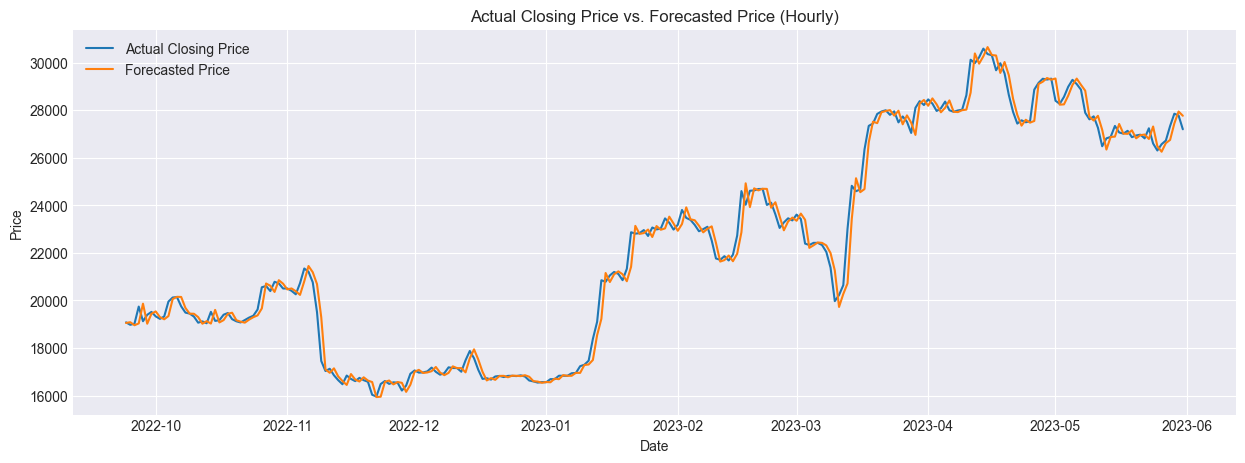

In [26]:
plt.figure(figsize=(15, 5))

plt.plot(merged_df['date'], merged_df['close'], label='Actual Closing Price')
plt.plot(merged_df['date'], merged_df['Daily_Forecast_ARIMA'], label='Forecasted Price')

plt.xlabel('Date')
plt.ylabel('Price')

plt.title('Actual Closing Price vs. Forecasted Price (Hourly)')

plt.legend()

plt.show()

In [27]:
# Results ARIMA Daily Model

test_mae_ar_d = round(mean_absolute_error(merged_df['close'], merged_df['Daily_Forecast_ARIMA']))
test_rmse_ar_d = round(np.sqrt(mean_squared_error(merged_df['close'], merged_df['Daily_Forecast_ARIMA'])))
test_r2_ar_d = round((r2_score(merged_df['close'], merged_df['Daily_Forecast_ARIMA']))*100, 2)

print(f"test MAE ARIMA : {test_mae_ar_d}")
print(f"test RMSE ARIMA : {test_rmse_ar_d}")
print(f"test R2 ARIMA : {test_r2_ar_d}")

test MAE ARIMA : 310
test RMSE ARIMA : 471
test R2 ARIMA : 98.88


## Results Modeling

In [28]:
# Overall Results

results = {
    "METRIC": ["MAE", "RMSE", "R2"],
    "ARIMA_Daily": [test_mae_ar_d, test_rmse_ar_d, test_r2_ar_d],
    "ARIMA_Hourly": [test_mae_ar_h, test_rmse_ar_h, test_r2_ar_h]

}

df_results = pd.DataFrame(results)
df_results

,METRIC,ARIMA_Daily,ARIMA_Hourly
0,MAE,310.00,77.00
1,RMSE,471.00,131.00
2,R2,98.88,98.86
